In [2]:
import psycopg2
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools

import numpy
from numpy import concatenate
from numpy import array

import seaborn as sns

import math
from math import sqrt

# ARIMA AND LSTM STUFF
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import time
import statsmodels.api as sm
import warnings

Using TensorFlow backend.


In [3]:
connection = psycopg2.connect(user = "equipo7",
                            password = "DLgndXy2m4hbWH-qn-Co",
                            host= "ds4a-demo-instance.cssn41frspmj.us-east-1.rds.amazonaws.com",
                            port = "5432",
                            database = "anahuac")
cursor = connection.cursor()
def runquery(query):
    df=pd.read_sql(query,connection)
    return df


def pivot_by_factor(df, index_table, column_table, value_table):
    df = pd.pivot_table(df, index = index_table, columns = column_table, values = value_table)
    df = df.sort_index(axis=1, level=1)
    df.columns = [f'{b}_{a}' for a, b in df.columns]
    df = df.reset_index()
    return df



## Load data from database

It was decided to take **2012 to 2018** as training data, **2019** as test and **january to february 2020** 
as validation for models, For base model **ARIMA**, it was decided to take **2015 to 2018** as trainig.

In [4]:
where_date_clause = " WHERE date >= '2012-01-01' AND date <= '2020-03-01 00:00:00' ORDER BY date"; 

sqlQuery_radiacion = "select * from processed_metrics.radiacion " + where_date_clause
df_radiacion = pd.DataFrame(runquery(sqlQuery_radiacion))

sqlQuery_rama = "select * from processed_metrics.rama " + where_date_clause
df_rama = pd.DataFrame(runquery(sqlQuery_rama))

sqlQuery_redmet = "select * from processed_metrics.redmet " + where_date_clause
df_redmet = pd.DataFrame(runquery(sqlQuery_redmet))

sqlQuery_presion = "select * from processed_metrics.presion " + where_date_clause
df_presion = pd.DataFrame(runquery(sqlQuery_presion))

sqlQuery_weather = "select date,fecha,hora,dewp_c AS dew_point_st,rh_st AS rain_st from processed_metrics.weather_fix  " + where_date_clause
df_weather = pd.DataFrame(runquery(sqlQuery_weather))

In [5]:
#radiation only has data until 2019-12-31 23:00:00. pressure has one more month but we will not consider it
#process radiation
df_radiacion = pivot_by_factor(df_radiacion,["date","fecha","hora"],["factor"],["st"])

#process pa
df_presion.rename(columns={'st': 'PA_st'}, inplace=True)
del df_presion['factor']

#process pollutants
df_rama = pivot_by_factor(df_rama,["date","fecha","hora"],["factor"],["st0","st1","st2"])

#process redmet
df_redmet = pivot_by_factor(df_redmet,["date","fecha","hora"],["factor"],["st0","st1","st2"])

#weather, we are interested in rain and dewpoint, already cleaned when reading from DB


In [6]:
#df_rama, df_redmet,df_weather 71568
#df_presion                    70824
#df_radiacion                  70128
dfs = [df_presion, df_radiacion, df_rama, df_redmet, df_weather]
for df in dfs:
    print("Shape : {} ".format(df.shape))
    print("NaN : {}\n".format(df.isna().sum()))

Shape : (70824, 4) 
NaN : date     0
fecha    0
hora     0
PA_st    8
dtype: int64

Shape : (70128, 5) 
NaN : date       0
fecha      0
hora       0
UVA_st     0
UVB_st    22
dtype: int64

Shape : (71568, 30) 
NaN : date        0
fecha       0
hora        0
CO_st0      0
CO_st1      0
CO_st2      0
NO_st0      0
NO_st1      0
NO_st2      0
NO2_st0     0
NO2_st1     0
NO2_st2     0
NOX_st0     0
NOX_st1     0
NOX_st2     0
O3_st0      0
O3_st1      0
O3_st2      0
PM10_st0    0
PM10_st1    0
PM10_st2    0
PM25_st0    0
PM25_st1    0
PM25_st2    0
PMCO_st0    0
PMCO_st1    0
PMCO_st2    0
SO2_st0     0
SO2_st1     0
SO2_st2     0
dtype: int64

Shape : (71568, 15) 
NaN : date       0
fecha      0
hora       0
RH_st0     0
RH_st1     0
RH_st2     0
TMP_st0    0
TMP_st1    0
TMP_st2    0
WDR_st0    0
WDR_st1    0
WDR_st2    0
WSP_st0    0
WSP_st1    0
WSP_st2    0
dtype: int64

Shape : (71569, 5) 
NaN : date            0
fecha           0
hora            0
dew_point_st    0
rain_st         

In [7]:
#merge all data as one
from functools import reduce
dfs = [df_rama, df_redmet, df_presion, df_radiacion, df_weather]
df_workspace = reduce(lambda left,right: pd.merge(left,right,on=['date','fecha','hora'], how='left'), dfs)


In [8]:
df_workspace.describe()

,hora,CO_st0,CO_st1,CO_st2,NO_st0,NO_st1,NO_st2,NO2_st0,NO2_st1,NO2_st2,...,WDR_st1,WDR_st2,WSP_st0,WSP_st1,WSP_st2,PA_st,UVA_st,UVB_st,dew_point_st,rain_st
count,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,...,71568.000000,71568.000000,71568.000000,71568.000000,71568.000000,70816.000000,70128.000000,70106.000000,71568.000000,71568.000000
mean,11.500000,2.182823,2.203050,2.081737,18.016768,20.176152,16.649986,21.182147,24.028906,26.303062,...,178.236301,153.656762,3.419663,3.605691,3.703279,584.714499,1.136723,0.794620,6.731408,47.179739
std,6.922235,1.123193,1.099021,0.961933,24.556083,27.079109,21.200509,8.878447,10.739216,11.030540,...,63.454682,66.697521,1.704319,1.791158,1.790861,1.551186,1.593015,1.260779,4.170254,16.810723
min,0.000000,0.014286,0.014286,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.500000,5.750000,0.275000,0.300000,0.300000,577.000000,0.000000,0.000000,-10.815000,5.759260
25%,5.750000,1.437500,1.444440,1.400000,4.888890,5.571430,4.500000,14.500000,16.333300,18.571400,...,134.200000,102.400000,1.866670,1.933330,2.075000,583.733000,0.000000,0.000000,4.200000,33.916700
50%,11.500000,2.120900,2.214290,2.128570,8.176190,9.375000,8.000000,20.139400,22.200000,24.777800,...,185.750000,145.800000,3.288890,3.628570,3.566670,584.800000,0.062775,0.011250,6.951380,48.634900
75%,17.250000,2.866670,2.925000,2.744440,19.777800,22.400000,19.833300,26.500000,29.625000,32.333300,...,226.857000,207.750000,4.757140,5.060000,5.140000,585.800000,2.112132,1.272362,9.478927,61.355600
max,23.000000,11.600000,8.700000,7.166670,250.000000,270.000000,281.125000,81.666700,111.000000,101.333000,...,304.429000,300.429000,10.466700,9.943330,9.600000,592.000000,6.195000,5.539570,22.000000,81.883600


In [9]:
df_workspace.columns

Index(['date', 'fecha', 'hora', 'CO_st0', 'CO_st1', 'CO_st2', 'NO_st0',
       'NO_st1', 'NO_st2', 'NO2_st0', 'NO2_st1', 'NO2_st2', 'NOX_st0',
       'NOX_st1', 'NOX_st2', 'O3_st0', 'O3_st1', 'O3_st2', 'PM10_st0',
       'PM10_st1', 'PM10_st2', 'PM25_st0', 'PM25_st1', 'PM25_st2', 'PMCO_st0',
       'PMCO_st1', 'PMCO_st2', 'SO2_st0', 'SO2_st1', 'SO2_st2', 'RH_st0',
       'RH_st1', 'RH_st2', 'TMP_st0', 'TMP_st1', 'TMP_st2', 'WDR_st0',
       'WDR_st1', 'WDR_st2', 'WSP_st0', 'WSP_st1', 'WSP_st2', 'PA_st',
       'UVA_st', 'UVB_st', 'dew_point_st', 'rain_st'],
      dtype='object')

In [10]:
df_workspace.fillna(method='ffill', inplace=True)

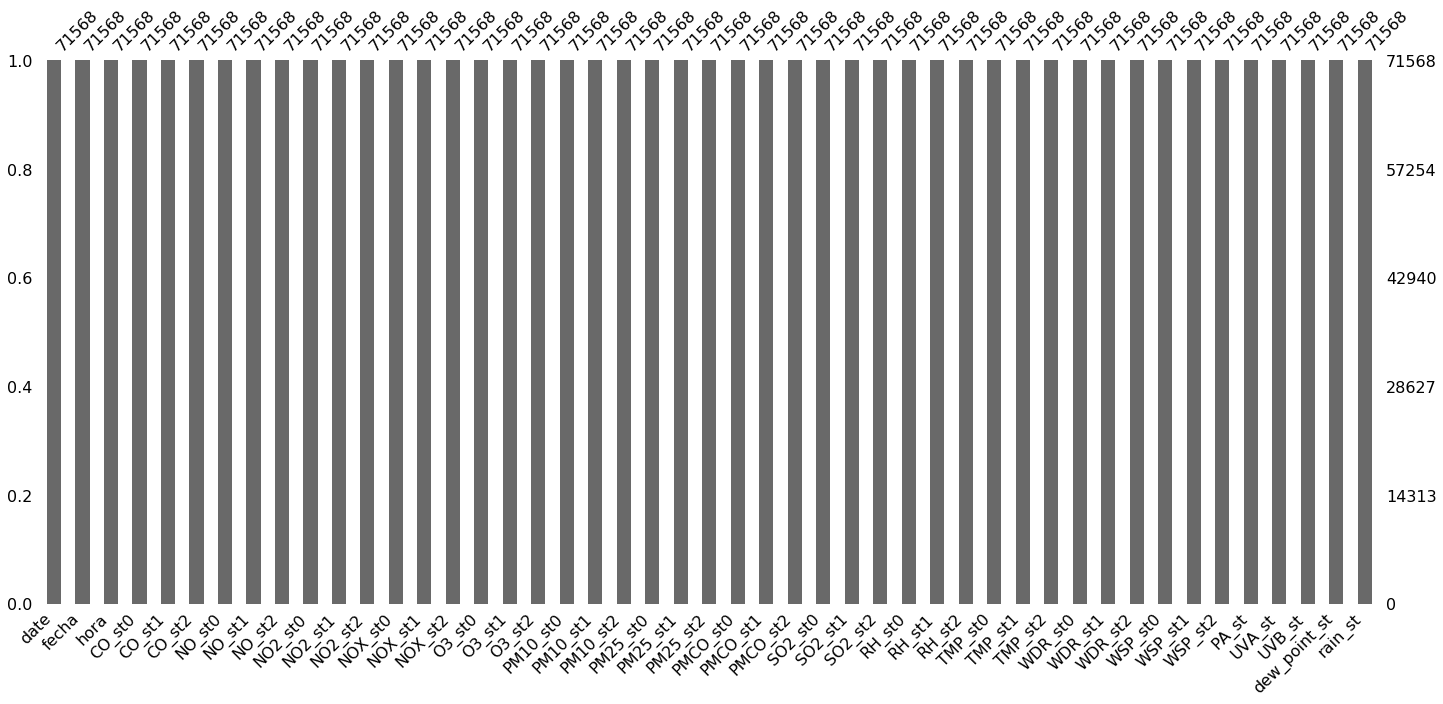

In [11]:
import missingno as msno 
#msno.matrix(df_workspace)  
msno.bar(df_workspace) 

In [12]:
def plot_resample_date(df,start_date,end_date, cols, resample_by):
    df[start_date:end_date][cols].resample(resample_by).mean().plot(figsize=(15, 6))
    plt.show()

In [13]:
# set date as index
df_workspace.set_index('date', inplace=True)

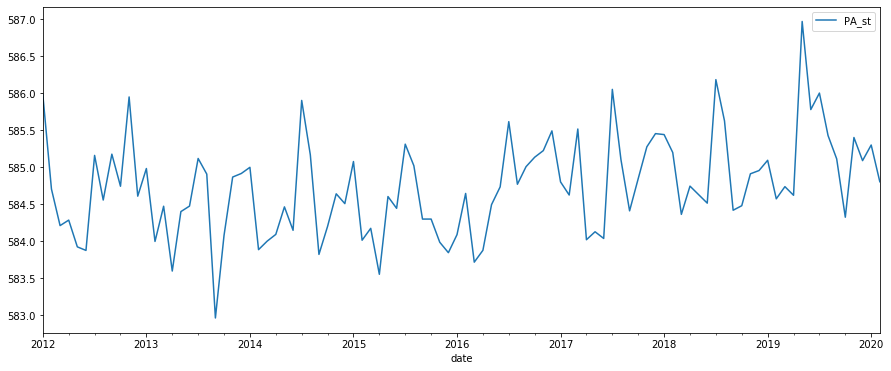

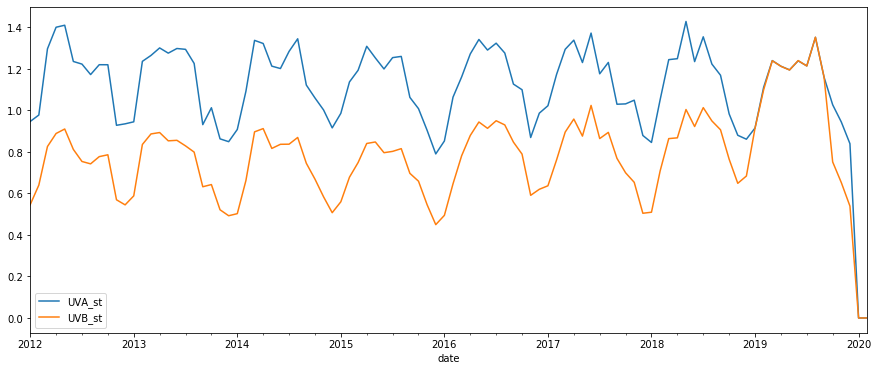

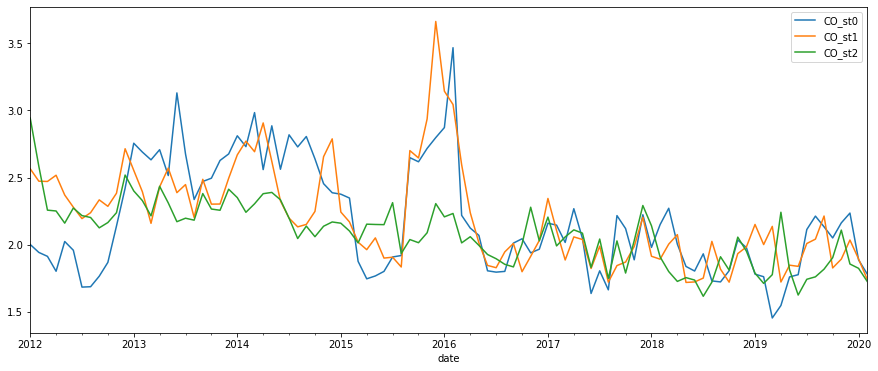

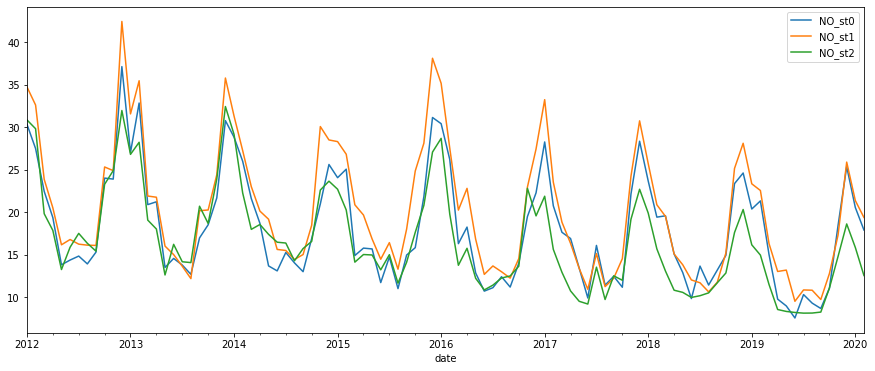

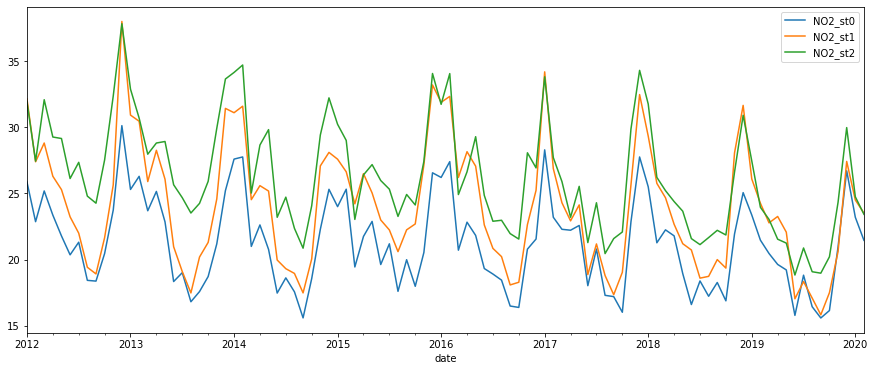

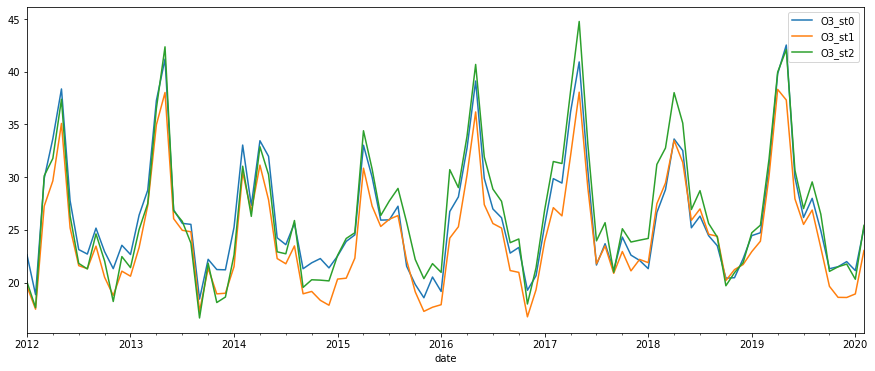

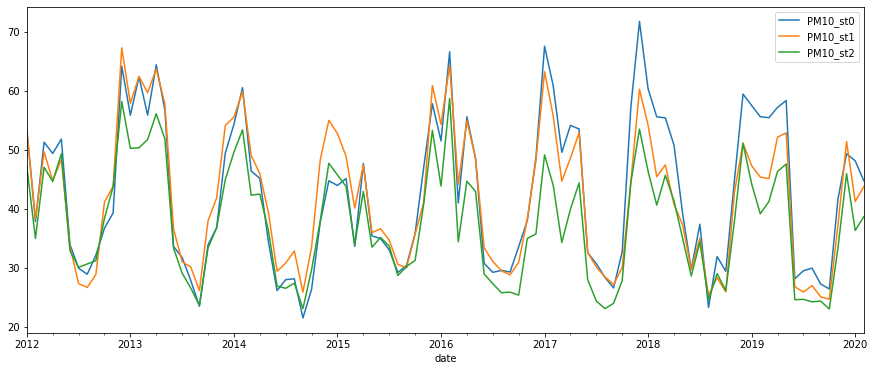

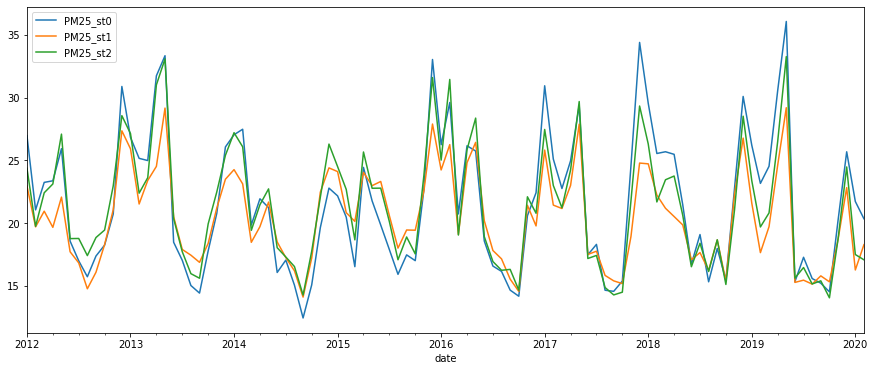

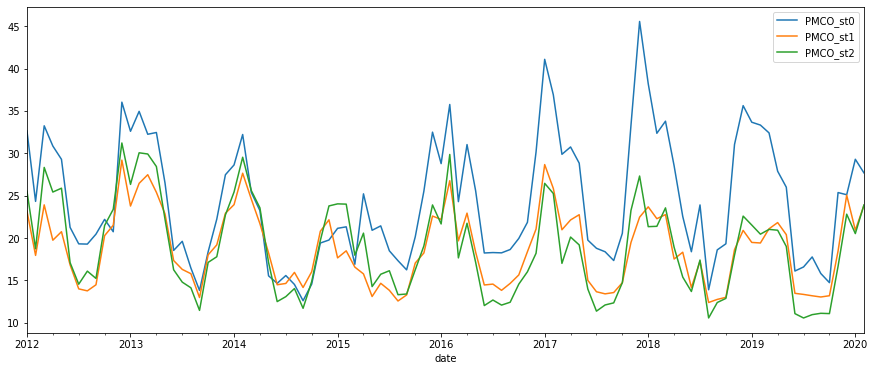

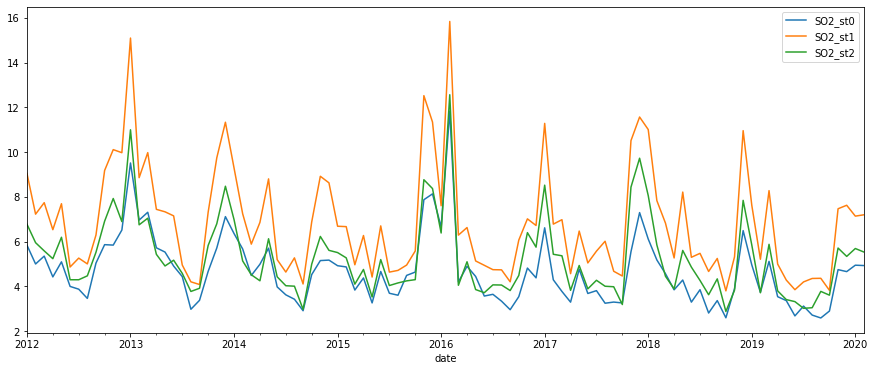

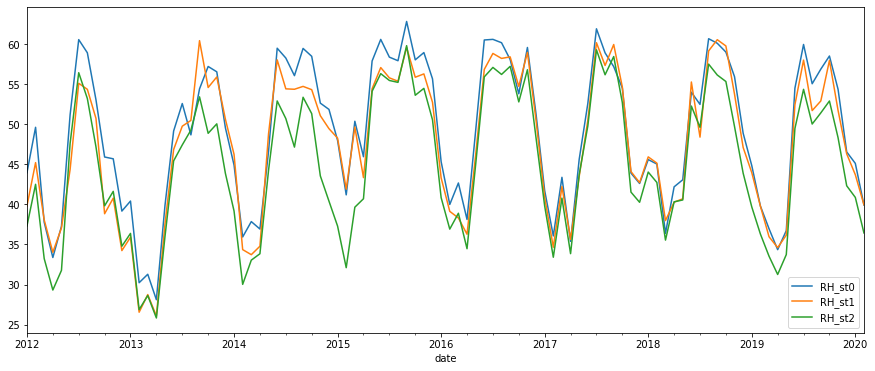

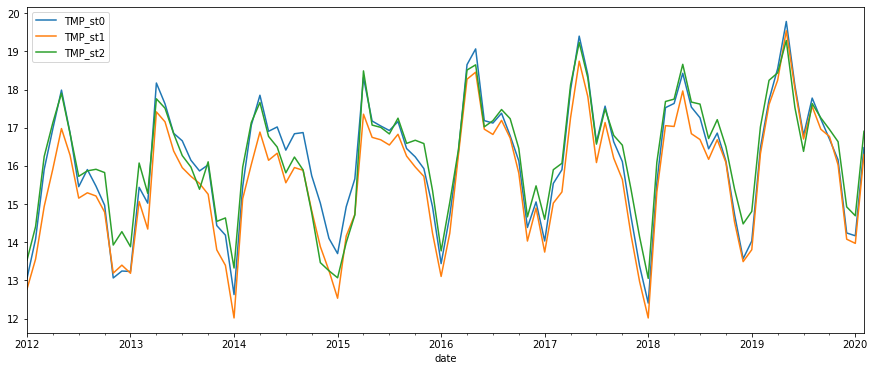

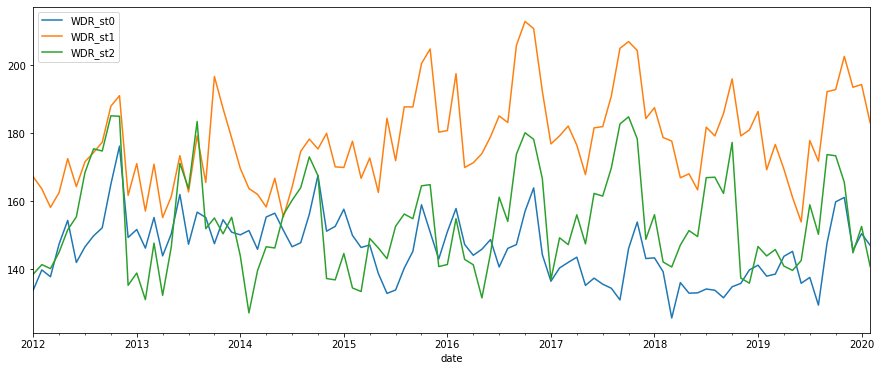

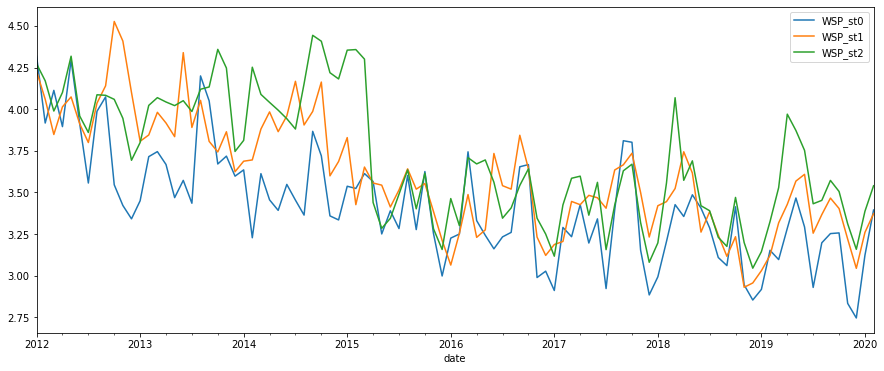

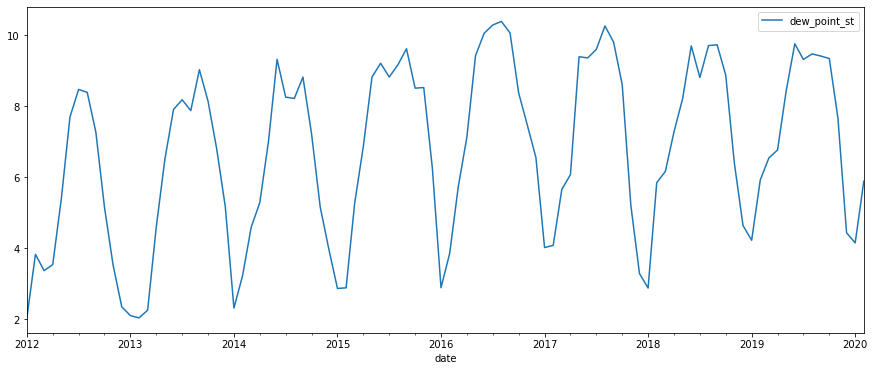

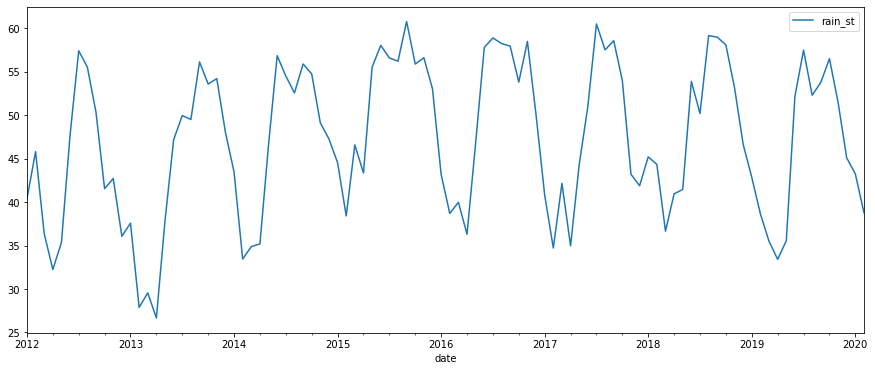

In [14]:
resample_by = 'MS'#'24H'
#for year in range(2012,2019):
#    print("SAMPLE BY 24 HRS BY YEAR: ", year)
start_year = str(2012)
end_year   = str(2020)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PA_st'], resample_by )
plot_resample_date(df_workspace,start_year,end_year ,[ 'UVA_st','UVB_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'CO_st0','CO_st1', 'CO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO_st0', 'NO_st1', 'NO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO2_st0', 'NO2_st1','NO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'O3_st0', 'O3_st1','O3_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM10_st0', 'PM10_st1', 'PM10_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM25_st0', 'PM25_st1', 'PM25_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PMCO_st0', 'PMCO_st1', 'PMCO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'SO2_st0', 'SO2_st1','SO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'RH_st0', 'RH_st1', 'RH_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'TMP_st0', 'TMP_st1','TMP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WDR_st0', 'WDR_st1', 'WDR_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WSP_st0', 'WSP_st1', 'WSP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'dew_point_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'rain_st'], resample_by)

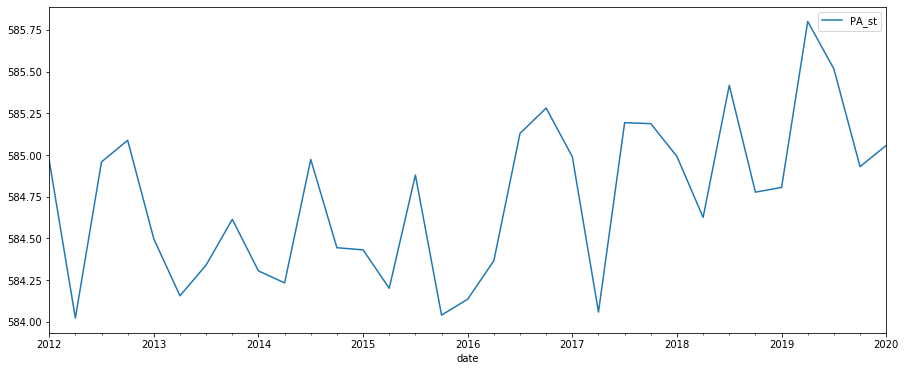

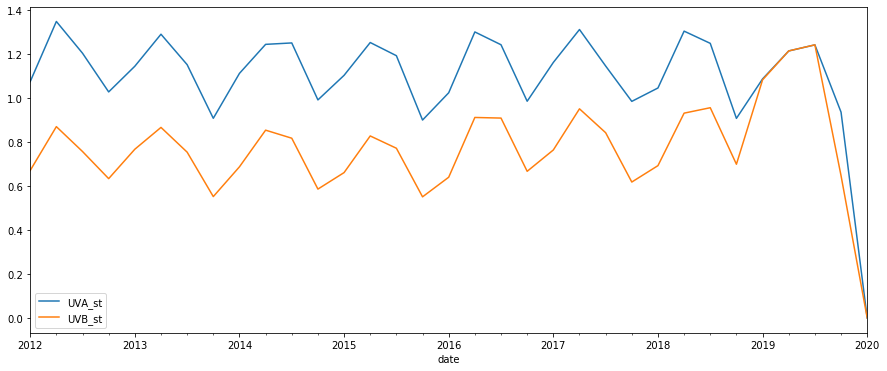

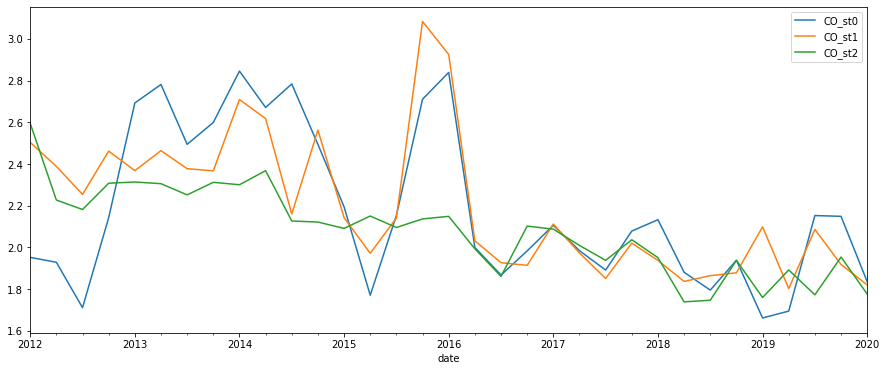

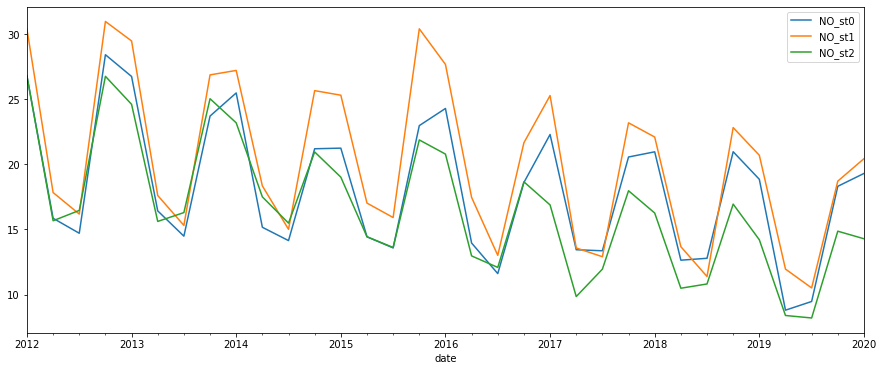

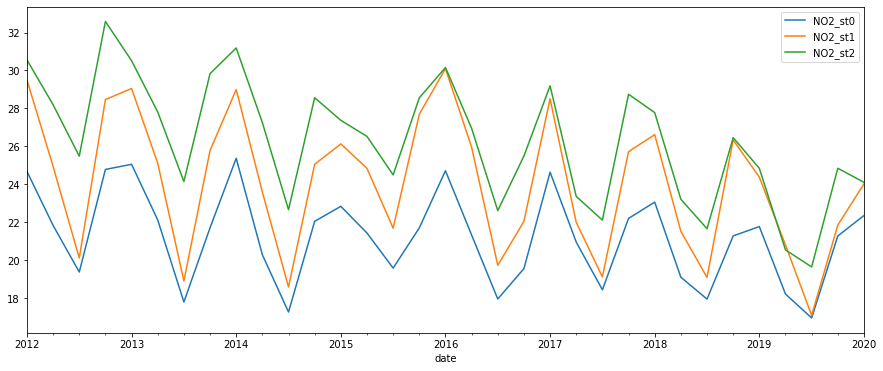

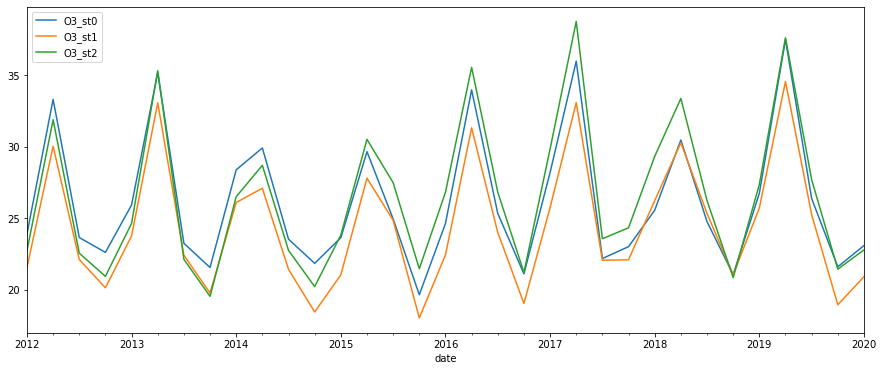

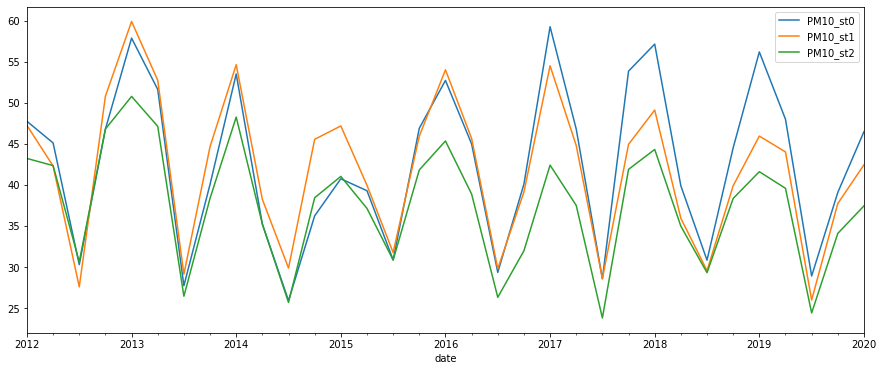

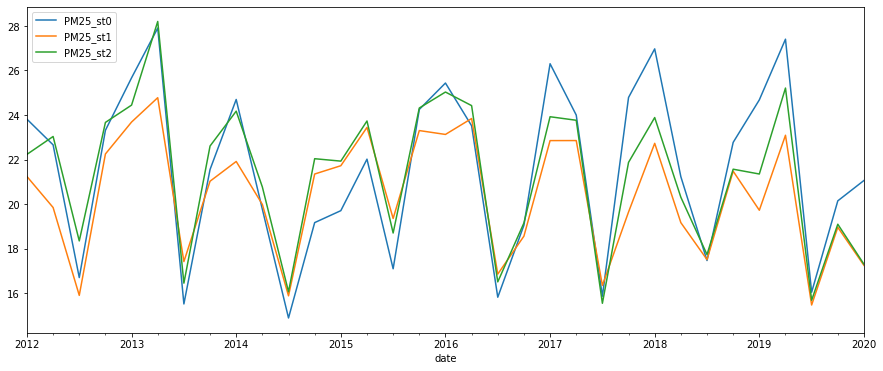

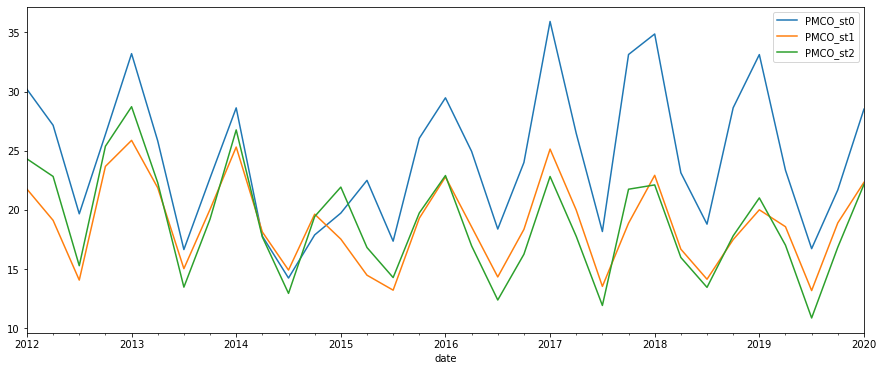

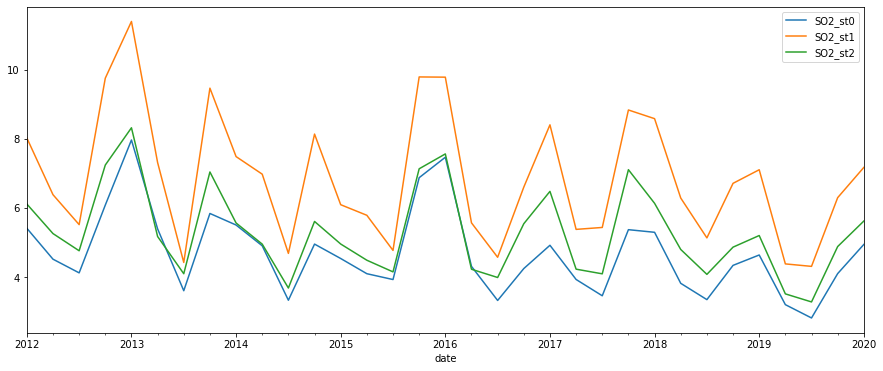

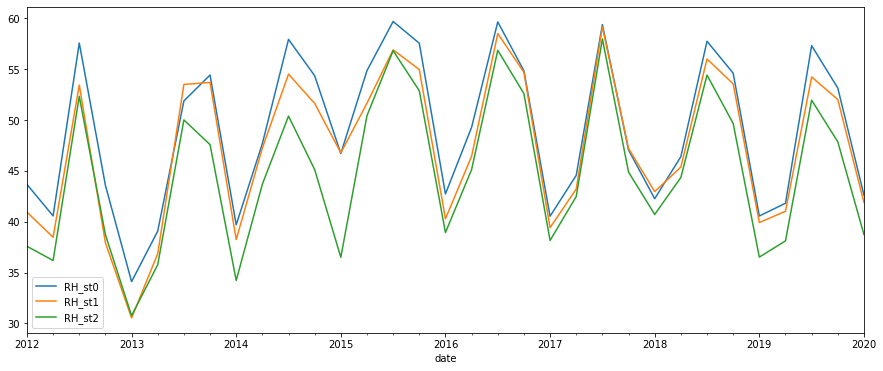

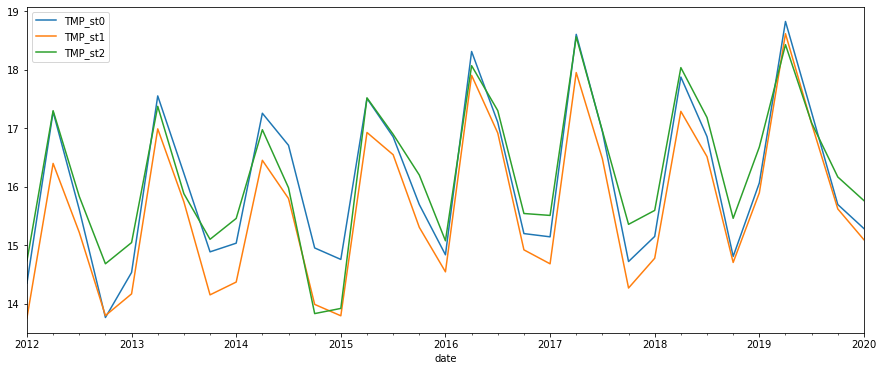

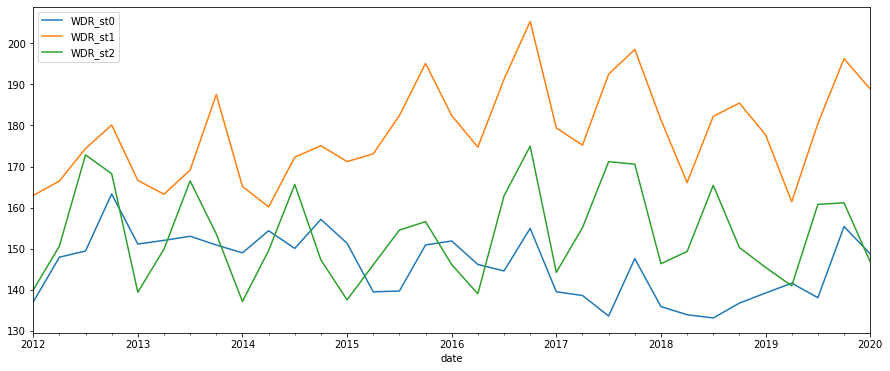

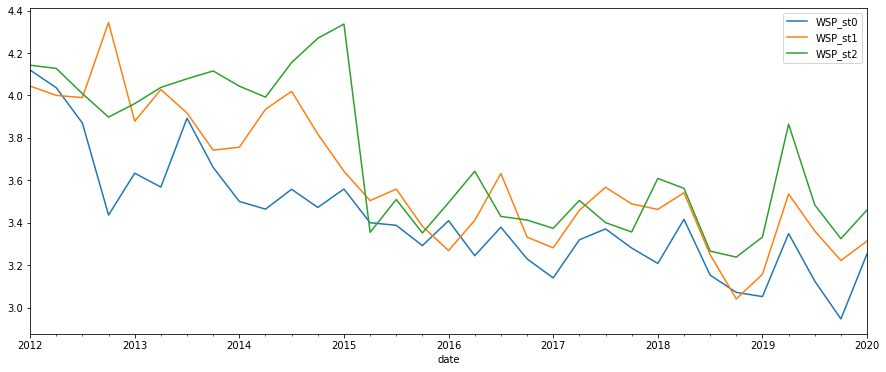

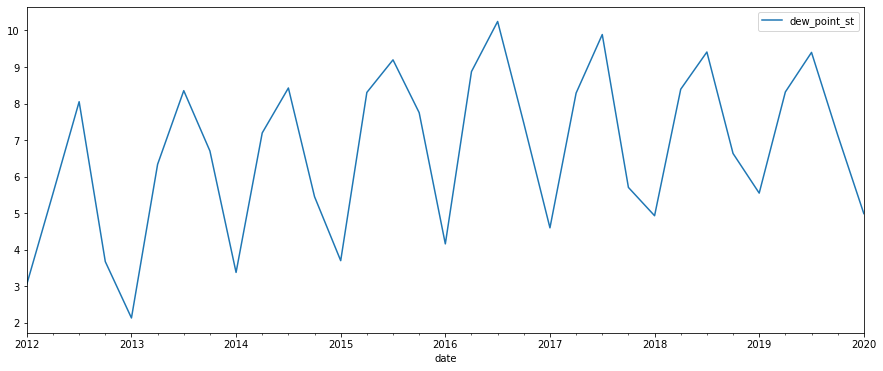

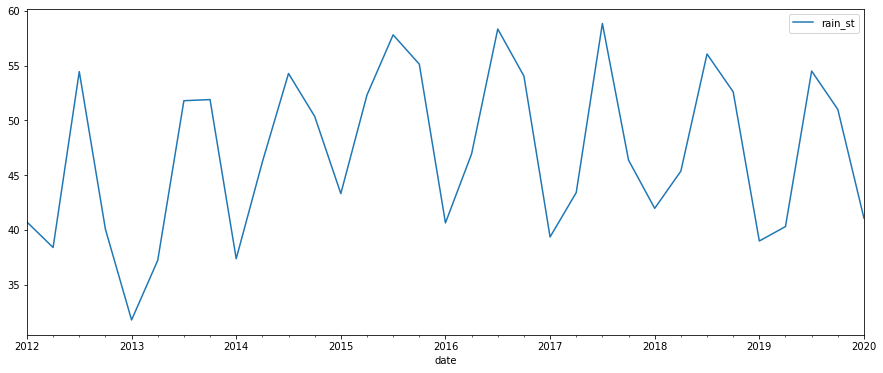

In [15]:
resample_by = 'Q'#'24H'
start_year = str(2012)
end_year   = str(2020)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PA_st'], resample_by )
plot_resample_date(df_workspace,start_year,end_year ,[ 'UVA_st','UVB_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'CO_st0','CO_st1', 'CO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO_st0', 'NO_st1', 'NO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO2_st0', 'NO2_st1','NO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'O3_st0', 'O3_st1','O3_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM10_st0', 'PM10_st1', 'PM10_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM25_st0', 'PM25_st1', 'PM25_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PMCO_st0', 'PMCO_st1', 'PMCO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'SO2_st0', 'SO2_st1','SO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'RH_st0', 'RH_st1', 'RH_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'TMP_st0', 'TMP_st1','TMP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WDR_st0', 'WDR_st1', 'WDR_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WSP_st0', 'WSP_st1', 'WSP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'dew_point_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'rain_st'], resample_by)

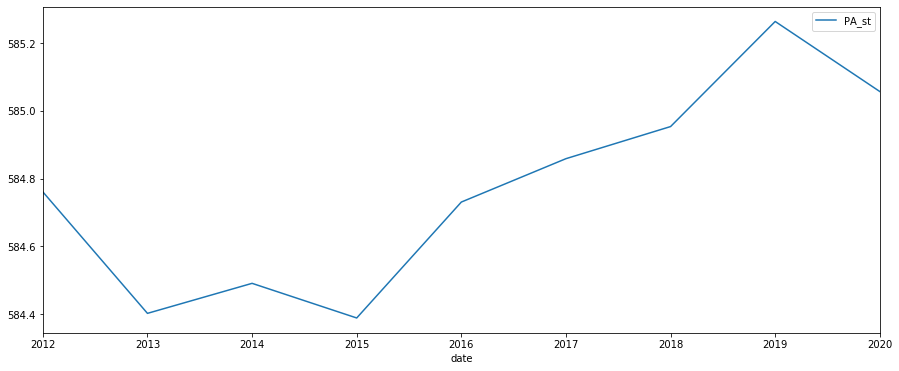

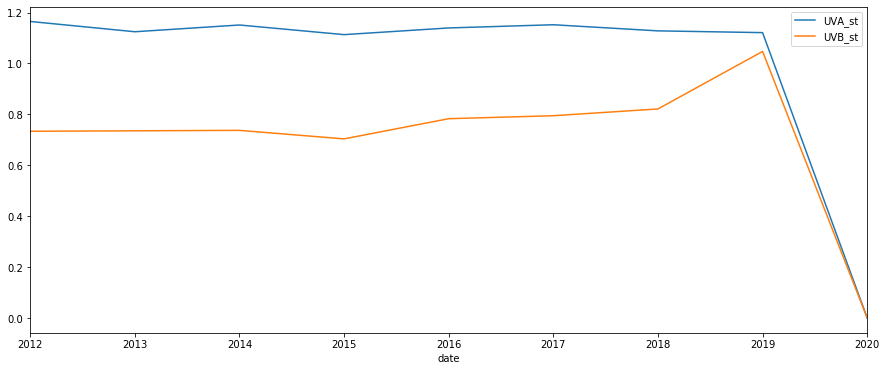

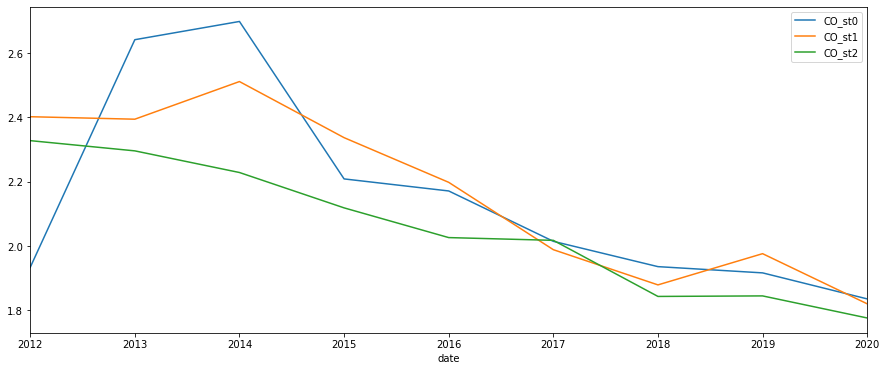

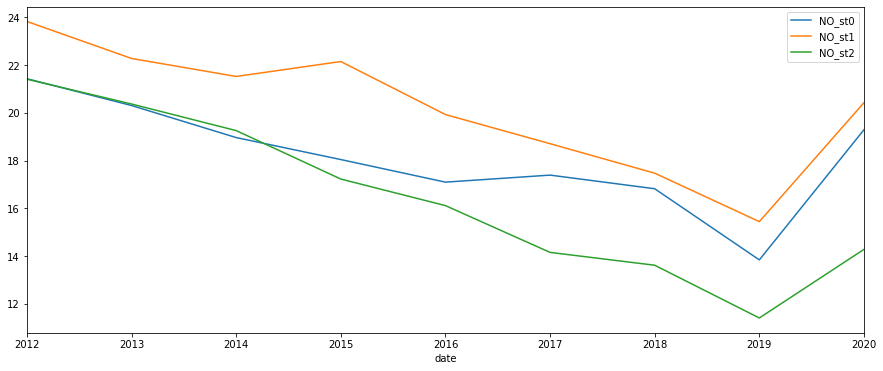

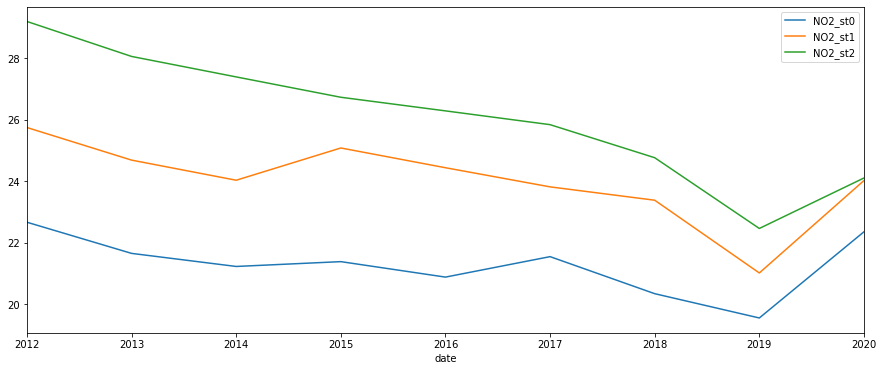

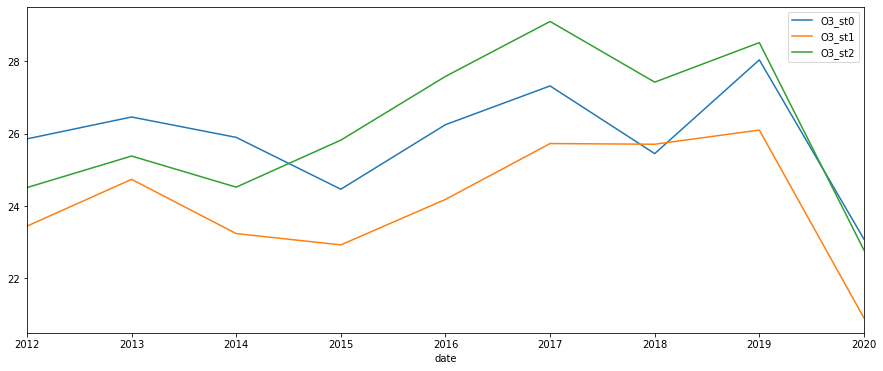

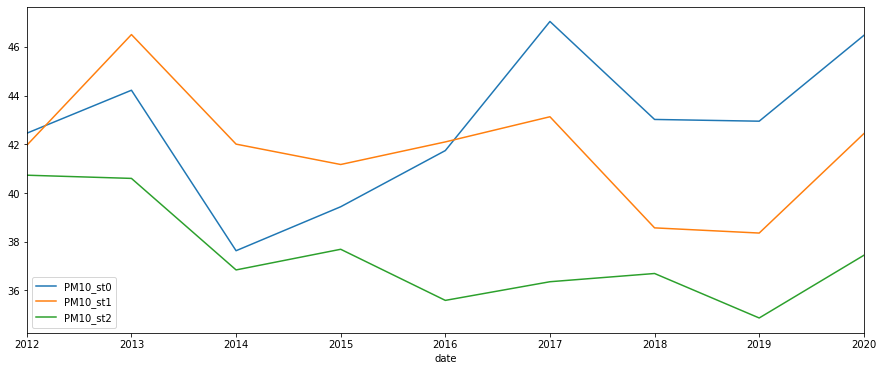

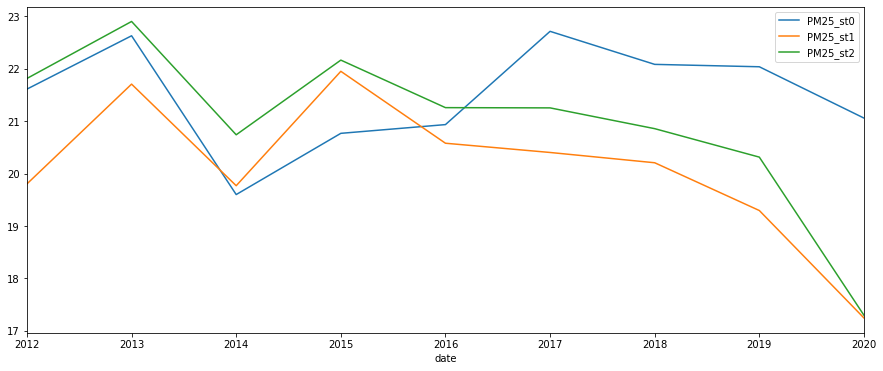

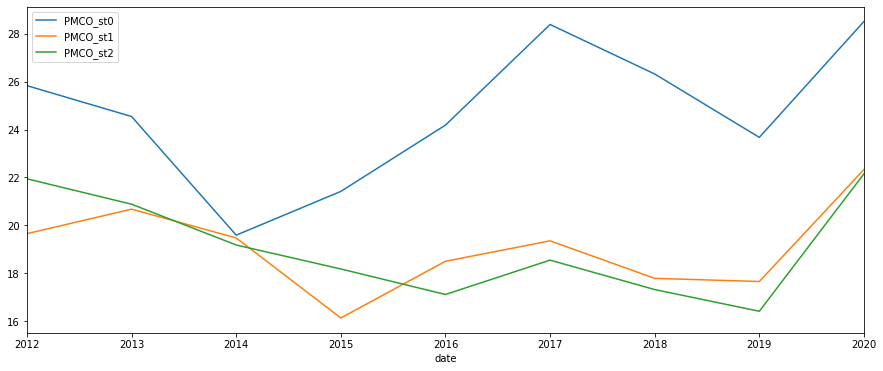

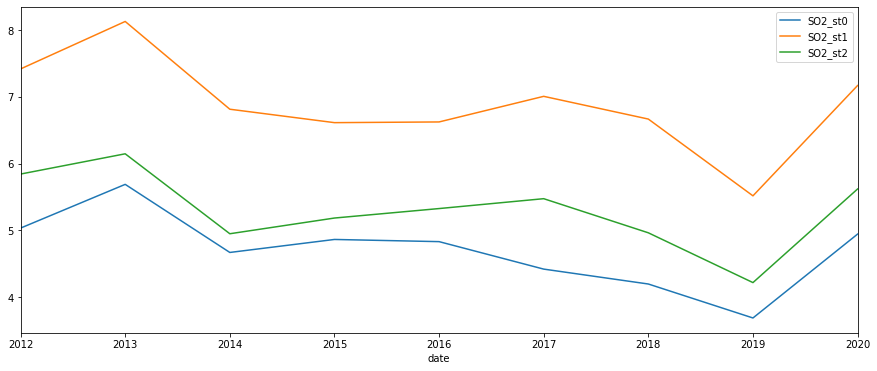

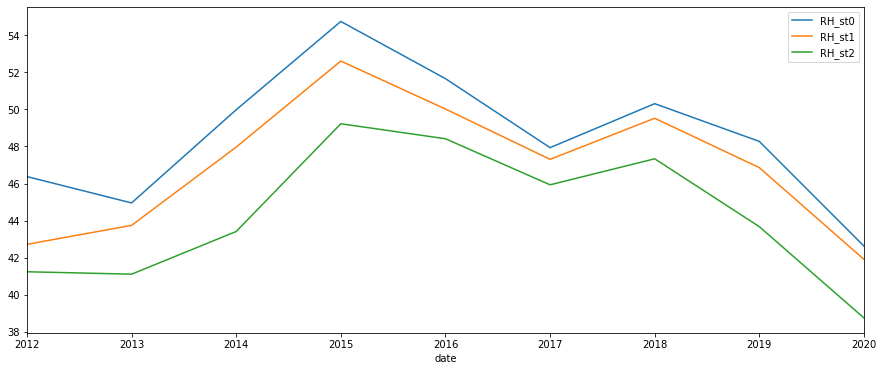

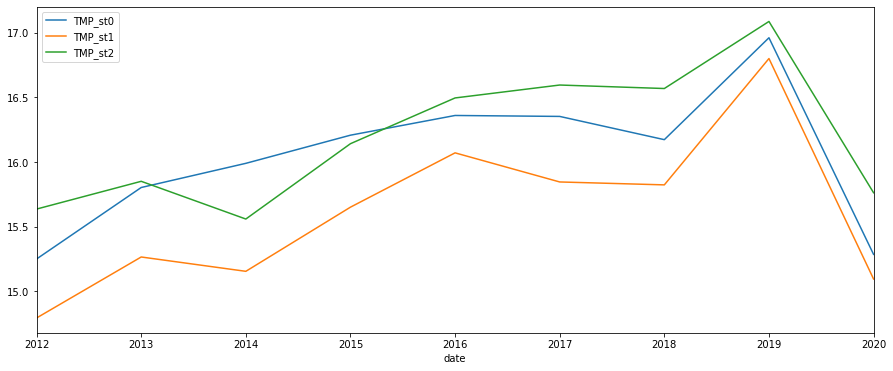

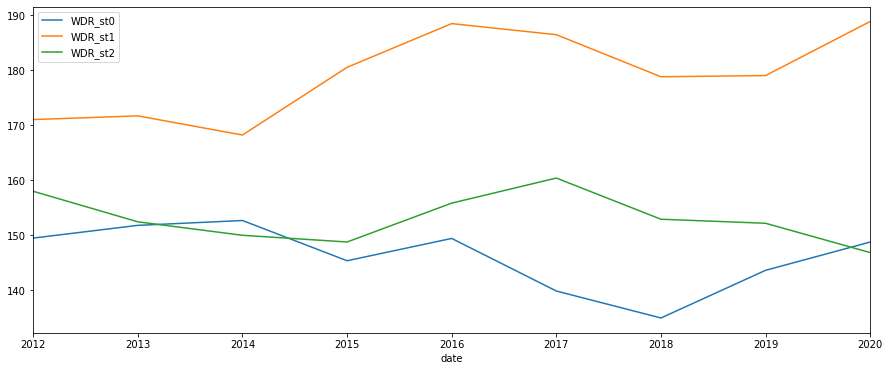

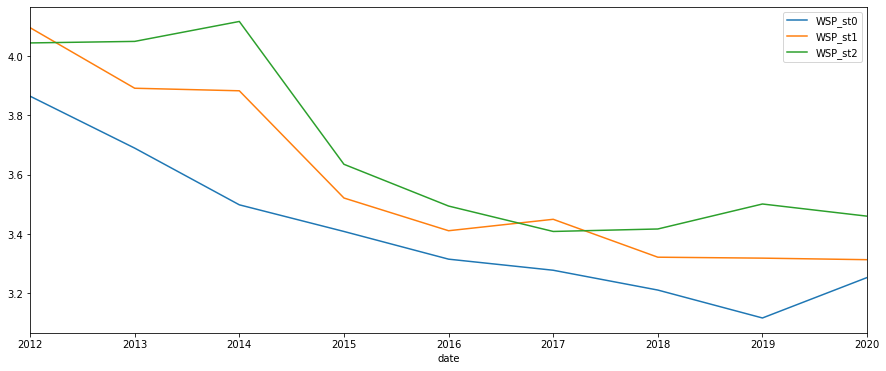

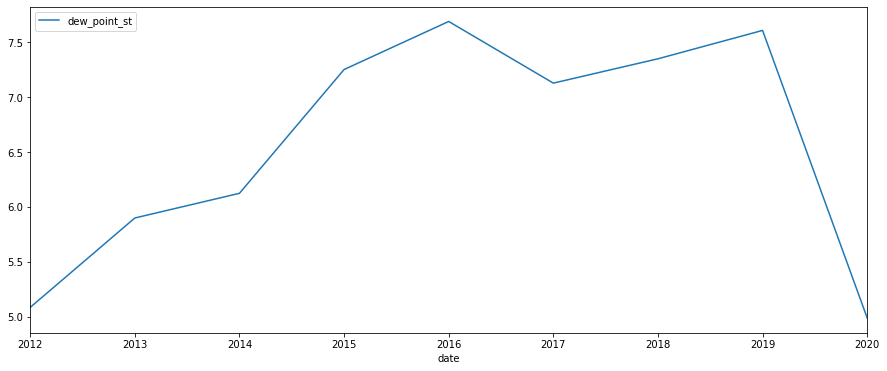

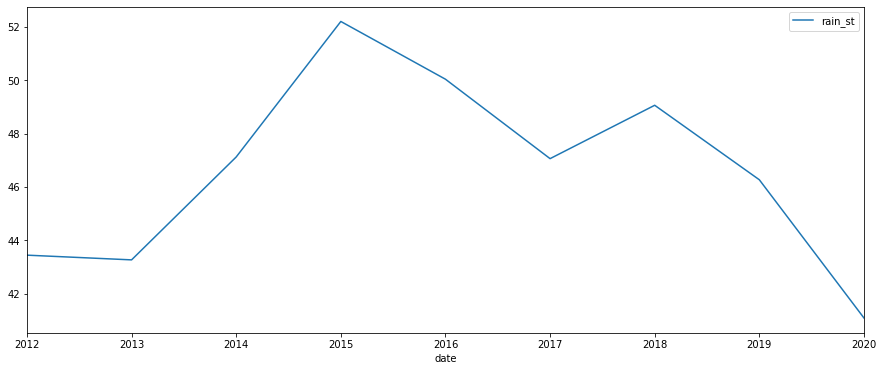

In [16]:
resample_by = 'Y'#'24H'
start_year = str(2012)
end_year   = str(2020)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PA_st'], resample_by )
plot_resample_date(df_workspace,start_year,end_year ,[ 'UVA_st','UVB_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'CO_st0','CO_st1', 'CO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO_st0', 'NO_st1', 'NO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'NO2_st0', 'NO2_st1','NO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'O3_st0', 'O3_st1','O3_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM10_st0', 'PM10_st1', 'PM10_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PM25_st0', 'PM25_st1', 'PM25_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'PMCO_st0', 'PMCO_st1', 'PMCO_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'SO2_st0', 'SO2_st1','SO2_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'RH_st0', 'RH_st1', 'RH_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'TMP_st0', 'TMP_st1','TMP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WDR_st0', 'WDR_st1', 'WDR_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'WSP_st0', 'WSP_st1', 'WSP_st2'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'dew_point_st'], resample_by)
plot_resample_date(df_workspace,start_year,end_year ,[ 'rain_st'], resample_by)

# Baseline model

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required. In this case pollution features will be predicted.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

    p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
    d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
    q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.




## Parameter Selection for the ARIMA Time Series Model

In [30]:

#pip install funcy
from funcy import print_durations
warnings.filterwarnings("ignore")

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    model = None
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return [error, model]

@print_durations()
# evaluate combinations of p, d and q values for an ARIMA model and retun best model
def evaluate_arima_models(train, test):
    best_score, best_cfg = float("inf"), None
    # Define the p, d and q parameters 
    p = [0]#, 1]
    d = [0]#,  24, 168, 744, 2976, 8928 ]
    q = [0]
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))    
    for order in pdq:
        try:
            [mse, current_model] = evaluate_arima_model(train, test, order)
            print('Current order= %s MSE=%.3f' % (order,mse))
            if mse < best_score:
                best_score, best_cfg = mse, order, current_model
                current_model.save('model_'+ m +'_.pkl')
        except:
            continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))    
    

    


In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

#Check autocorrelation to have an idea of parameters
q_test = df_workspace['CO_st0'].resample('W').mean()
autocorrelation_plot(q_test)


In [ ]:
plot_pacf(q_test, lags=24)

In [ ]:
from sklearn.utils import check_array
from functools import partial
from multiprocessing import Pool
from funcy import print_durations

def get_aic_bic(order,series):
    aic=np.nan
    bic=np.nan
    #print(series.shape,order)
    try:
        arima_mod=statsmodels.tsa.arima_model.ARIMA(series,order=order,freq='H').fit(transparams=True,method='css')
        aic=arima_mod.aic
        bic=arima_mod.bic
        print(order,aic,bic)
    except:
        pass
    return aic,bic

@print_durations()
def get_PDQ_parallel(data,n_jobs=7):
    p_val=13
    q_val=13
    d_vals=2
    pdq_vals=[ (p,d,q) for p in range(p_val) for d in range(d_vals) for q in range(q_val)]
    get_aic_bic_partial=partial(get_aic_bic,series=data)
    p = Pool(n_jobs)
    res=p.map(get_aic_bic_partial, pdq_vals)  
    p.close()
    return pd.DataFrame(res,index=pdq_vals,columns=['aic','bic']) 

In [ ]:
#df_pdq = get_PDQ_parallel(df_workspace['2017-01-01':'2019-12-31']['CO_st0'],7)
#df_pdq

# Create train test dataframes

In [23]:
train_arima      = df_workspace['2018-01-01':'2019-12-31']
test_arima       = df_workspace['2019-01-01':'2019-12-31']
validation_arima = df_workspace['2020-01-01':'2020-02-29']

train_hours      = len(train_arima)
test_hours       = len(test_arima)
validation_hours = len(train_arima)


print(train_arima.shape)
print(test_arima.shape)
print(validation_arima.shape)


(17520, 46)
(8760, 46)
(1440, 46)


In [31]:
arima_models = ['O3_st0']

'''arima_models = ['CO_st0', 'CO_st1', 'CO_st2', 'NO_st0', 'NO_st1','NO_st2', 'NO2_st0', 'NO2_st1', 'NO2_st2', 
                'NOX_st0', 'NOX_st1','NOX_st2', 'O3_st0', 'O3_st1', 'O3_st2', 'PM10_st0', 'PM10_st1','PM10_st2', 
                'PM25_st0', 'PM25_st1', 'PM25_st2', 'PMCO_st0', 'PMCO_st1','PMCO_st2', 'SO2_st0', 'SO2_st1', 
                'SO2_st2', 'RH_st0', 'RH_st1','RH_st2', 'TMP_st0', 'TMP_st1', 'TMP_st2', 'WDR_st0', 'WDR_st1',
                'WDR_st2', 'WSP_st0', 'WSP_st1', 'WSP_st2', 'PA_st', 'UVA_st','UVB_st']'''

for m in arima_models:
    best_arima_model = evaluate_arima_models(train_arima[m],test_arima[m]) 
    

Current order= (0, 0, 0) MSE=495.258
Best ARIMANone MSE=inf
   65.55 s in evaluate_arima_models(date 2018-01-01 00:00:..., date 2019-01-01 00:00:...)


# Univariate LSTM

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #initializing the neural network
    model = Sequential()
    #Long Short-Term Memory layer
    model.add(LSTM(
        neurons, 
        batch_input_shape = (batch_size, X.shape[1], X.shape[2]), 
        stateful=True)
             )
    #Dense is a layer type (fully connected layer)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    #for i in range(nb_epoch):
    #    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #    model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 

def evaluate_lst_model(data):
    # transform data to be stationary
    raw_values = data.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train start:training_hours and test training_hours:end  sets
    
    
    
    train, test , supervised_values[training_hours:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit the model
    print("number of hours for training {}".format(len(train_scaled)))
    # fit the model
    
    
df_workspace['NO2_st0']    